In [ ]:
# %pip install torch transformers datasets scikit-learn matplotlib seaborn tqdm pandas -q

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from tqdm.auto import tqdm
import warnings
import random
import json

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

/Users/gab1k/Desktop/hse_dl_4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS (Apple Silicon)
Device: mps


Используем датасет AG News - новостной текстовый датасет с 4 классами ['World', 'Sports', 'Business', 'Sci/Tech'] с соответствующей индексацией [0, 1, 2, 3]

In [3]:
dataset = load_dataset("ag_news")
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [4]:
import collections
TRAIN_SIZE = 10000
TEST_SIZE = 2000

train_data = dataset['train'].shuffle(seed=42).select(range(TRAIN_SIZE))
test_data = dataset['test'].shuffle(seed=42).select(range(TEST_SIZE))

print("Распределение train:", collections.Counter(train_data['label']))
print("Распределение test:", collections.Counter(test_data['label']))

Распределение train: Counter({3: 2535, 0: 2530, 1: 2528, 2: 2407})
Распределение test: Counter({2: 522, 3: 498, 0: 497, 1: 483})


В качестве модели возьмем distilbert-base-uncased для скорости

In [5]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LENGTH = 128
BATCH_SIZE = 32

class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=MAX_LENGTH):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        label = item['label']
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextClassificationDataset(train_data, tokenizer)
test_dataset = TextClassificationDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Реализация NeuralNDCG Loss

In [6]:
class NeuralNDCGLoss(nn.Module):    
    def __init__(self, temperature=1.0, k=None):
        super().__init__()
        self.temperature = temperature
        self.k = k
    
    def _compute_approx_permutation_matrix(self, scores):
        batch_size, n = scores.shape
        
        # B[i,j] = (n+1-2j)*s_i
        B = (n + 1 - 2 * torch.arange(1, n+1, device=scores.device).float()).view(1, 1, n)
        B = B * scores.unsqueeze(2)  # (batch, n, n)
        
        scores_expanded = scores.unsqueeze(2)  # (batch, n, 1)
        scores_transposed = scores.unsqueeze(1)  # (batch, 1, n)
        A = torch.abs(scores_expanded - scores_transposed)  # (batch, n, n)
        
        C = A.sum(dim=2, keepdim=True)  # (batch, n, 1)
        
        P = B - C
        P = F.softmax(P / self.temperature, dim=1)
        
        return P
    
    def _dcg(self, relevance, k=None):
        n = relevance.shape[1]
        if k is None:
            k = n
        k = min(k, n)
        
        gains = torch.pow(2.0, relevance[:, :k]) - 1
        
        positions = torch.arange(1, k + 1, device=relevance.device).float()
        discounts = 1.0 / torch.log2(positions + 1)
        
        dcg = (gains * discounts).sum(dim=1)
        return dcg
    
    def forward(self, predicted_scores, relevance_labels):
        # Получаем soft permutation matrix
        P = self._compute_approx_permutation_matrix(predicted_scores)
        
        # Применяем перестановку к релевантностям
        sorted_relevance = torch.bmm(P, relevance_labels.unsqueeze(2)).squeeze(2)
        
        # Вычисляем DCG для предсказанного ранжирования
        dcg = self._dcg(sorted_relevance, self.k)
        
        # Вычисляем идеальный DCG (IDCG)
        ideal_sorted_relevance, _ = torch.sort(relevance_labels, dim=1, descending=True)
        idcg = self._dcg(ideal_sorted_relevance, self.k)
        
        ndcg = dcg / (idcg + 1e-10)
        loss = 1.0 - ndcg.mean()
        
        return loss


Проверим реализацию

In [7]:
ndcg_loss = NeuralNDCGLoss(temperature=1.0)

loss_perfect = ndcg_loss(predicted_scores=torch.tensor([[3.0, 2.0, 1.0, 0.0]]), 
                         relevance_labels=torch.tensor([[1.0, 0.0, 0.0, 0.0]]))

loss_bad = ndcg_loss(predicted_scores=torch.tensor([[0.0, 1.0, 2.0, 3.0]]), 
                         relevance_labels=torch.tensor([[1.0, 0.0, 0.0, 0.0]]))
print(f"Идеальное ранжирование: loss = {loss_perfect.item():.4f}")
print(f"Плохое ранжирование: loss = {loss_bad.item():.4f}")

Идеальное ранжирование: loss = 0.2193
Плохое ранжирование: loss = 0.6138


Выглядит разумно

## Создаем модель на основе DistilBERT с возможностью использования NeuralNDCG loss

In [8]:
class TextClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout=0.1):
        super().__init__()
        
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size
        
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        
        return logits

num_classes = len(class_names)
model = TextClassifier(MODEL_NAME, num_classes).to(device)

print(f"Всего параметров в модели: {sum(p.numel() for p in model.parameters())}")

Всего параметров в модели: 66365956


## Заведем функции обучения и оценки

In [9]:
def train_epoch(model, train_loader, optimizer, scheduler, ce_criterion, 
                ndcg_criterion=None, lambda_rank=0.0, device=device):

    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_rank_loss = 0
    num_batches = 0
    
    for batch in tqdm(train_loader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        
        ce_loss = ce_criterion(logits, labels)
        
        # Ranking loss (NeuralNDCG)
        rank_loss = torch.tensor(0.0, device=device)
        if ndcg_criterion is not None and lambda_rank > 0:
            relevance = F.one_hot(labels, num_classes=num_classes).float()
            rank_loss = ndcg_criterion(logits, relevance)
        
        loss = ce_loss + lambda_rank * rank_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        total_rank_loss += rank_loss.item() if lambda_rank > 0 else 0
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    avg_rank_loss = total_rank_loss / num_batches
    
    return avg_loss, avg_ce_loss, avg_rank_loss


def evaluate(model, test_loader, device=device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
        'precision_macro': precision_score(all_labels, all_preds, average='macro'),
        'recall_macro': recall_score(all_labels, all_preds, average='macro'),
    }

    for k in [1, 2, 3]:
        top_k_preds = np.argsort(all_probs, axis=1)[:, -k:]
        top_k_correct = np.array([all_labels[i] in top_k_preds[i] for i in range(len(all_labels))])
        metrics[f'top_{k}_accuracy'] = top_k_correct.mean()
    
    return metrics, all_preds, all_labels, all_probs


def compute_ndcg_metric(probs, labels, k=None):
    n_samples, n_classes = probs.shape
    if k is None:
        k = n_classes
    
    ndcg_scores = []
    
    for i in range(n_samples):
        relevance = np.zeros(n_classes)
        relevance[labels[i]] = 1.0
        
        ranking = np.argsort(probs[i])[::-1]
        sorted_relevance = relevance[ranking]

        gains = np.power(2.0, sorted_relevance[:k]) - 1
        discounts = 1.0 / np.log2(np.arange(1, k+1) + 1)
        dcg = np.sum(gains * discounts)
        
        ideal_relevance = np.sort(relevance)[::-1]
        ideal_gains = np.power(2.0, ideal_relevance[:k]) - 1
        idcg = np.sum(ideal_gains * discounts)
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
    
    return np.mean(ndcg_scores)


## И наконец обучим две модели:
1 Только CrossEntropy loss

2 CrossEntropy + NeuralNDCG loss


In [10]:
def train_model(model_name, num_classes, train_loader, test_loader, 
                num_epochs=4, lr=2e-5, lambda_rank=0.0, temperature=1.0):
    model = TextClassifier(model_name, num_classes)
    model = model.to(device)

    ce_criterion = nn.CrossEntropyLoss()
    ndcg_criterion = NeuralNDCGLoss(temperature=temperature) if lambda_rank > 0 else None
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
    )

    history = {'train_loss': [], 'train_ce_loss': [], 'train_rank_loss': [],
               'test_accuracy': [], 'test_f1': [], 'test_ndcg': [],
               'test_top_1': [], 'test_top_2': [], 'test_top_3': []}
    
    mode_str = "CE + NeuralNDCG" if lambda_rank > 0 else "CE only"
    print(f"\n{'='*60}\nОбучение модели: {mode_str} (λ={lambda_rank})\n{'='*60}")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        train_loss, train_ce_loss, train_rank_loss = train_epoch(
            model, train_loader, optimizer, scheduler, 
            ce_criterion, ndcg_criterion, lambda_rank, device
        )
        
        metrics, preds, labels, probs = evaluate(model, test_loader, device)
        ndcg = compute_ndcg_metric(probs, labels)
        
        history['train_loss'].append(train_loss)
        history['train_ce_loss'].append(train_ce_loss)
        history['train_rank_loss'].append(train_rank_loss)
        history['test_accuracy'].append(metrics['accuracy'])
        history['test_f1'].append(metrics['f1_macro'])
        history['test_ndcg'].append(ndcg)
        history['test_top_1'].append(metrics['top_1_accuracy'])
        history['test_top_2'].append(metrics['top_2_accuracy'])
        history['test_top_3'].append(metrics['top_3_accuracy'])
        
        print(f"Train Loss: {train_loss:.4f} (CE: {train_ce_loss:.4f}, Rank: {train_rank_loss:.4f})")
        print(f"Test Acc: {metrics['accuracy']:.4f}, F1: {metrics['f1_macro']:.4f}, NDCG: {ndcg:.4f}")
        print(f"Top-1: {metrics['top_1_accuracy']:.4f}, Top-2: {metrics['top_2_accuracy']:.4f}")
    
    final_metrics, final_preds, final_labels, final_probs = evaluate(model, test_loader, device)
    final_ndcg = compute_ndcg_metric(final_probs, final_labels)
    
    print(f"\nФинальные результаты ({mode_str}):")
    print(f"  Accuracy: {final_metrics['accuracy']:.4f}, F1: {final_metrics['f1_macro']:.4f}")
    print(f"  NDCG: {final_ndcg:.4f}, Top-2 Acc: {final_metrics['top_2_accuracy']:.4f}")
    
    return model, history, (final_metrics, final_preds, final_labels, final_probs)


Только CrossEntropy loss

In [11]:
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
LAMBDA_RANK = 0.5

model_baseline, history_baseline, results_baseline = train_model(
    MODEL_NAME, num_classes, train_loader, test_loader,
    num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, lambda_rank=0.0
)



Обучение модели: CE only (λ=0.0)

Epoch 1/5


Train Loss: 0.5500 (CE: 0.5500, Rank: 0.0000)
Test Acc: 0.8985, F1: 0.9001, NDCG: 0.9601
Top-1: 0.8985, Top-2: 0.9830

Epoch 2/5


Train Loss: 0.2207 (CE: 0.2207, Rank: 0.0000)
Test Acc: 0.9025, F1: 0.9035, NDCG: 0.9622
Top-1: 0.9025, Top-2: 0.9875

Epoch 3/5


Train Loss: 0.1414 (CE: 0.1414, Rank: 0.0000)
Test Acc: 0.9130, F1: 0.9138, NDCG: 0.9661
Top-1: 0.9130, Top-2: 0.9870

Epoch 4/5


Train Loss: 0.0914 (CE: 0.0914, Rank: 0.0000)
Test Acc: 0.9125, F1: 0.9135, NDCG: 0.9662
Top-1: 0.9125, Top-2: 0.9890

Epoch 5/5


Train Loss: 0.0622 (CE: 0.0622, Rank: 0.0000)
Test Acc: 0.9100, F1: 0.9110, NDCG: 0.9647
Top-1: 0.9100, Top-2: 0.9860



Финальные результаты (CE only):
  Accuracy: 0.9100, F1: 0.9110
  NDCG: 0.9647, Top-2 Acc: 0.9860


CrossEntropy + NeuralNDCG loss

In [12]:
model_ndcg, history_ndcg, results_ndcg = train_model(
    MODEL_NAME, num_classes, train_loader, test_loader,
    num_epochs=NUM_EPOCHS, lr=LEARNING_RATE, lambda_rank=LAMBDA_RANK, temperature=1.0
)



Обучение модели: CE + NeuralNDCG (λ=0.5)

Epoch 1/5


Train Loss: 0.7079 (CE: 0.5733, Rank: 0.2692)
Test Acc: 0.9000, F1: 0.9009, NDCG: 0.9605
Top-1: 0.9000, Top-2: 0.9820

Epoch 2/5


Train Loss: 0.2978 (CE: 0.2459, Rank: 0.1038)
Test Acc: 0.9120, F1: 0.9130, NDCG: 0.9644
Top-1: 0.9120, Top-2: 0.9805

Epoch 3/5


Train Loss: 0.2013 (CE: 0.1680, Rank: 0.0665)
Test Acc: 0.9075, F1: 0.9087, NDCG: 0.9628
Top-1: 0.9075, Top-2: 0.9805

Epoch 4/5


Train Loss: 0.1406 (CE: 0.1178, Rank: 0.0456)
Test Acc: 0.9140, F1: 0.9150, NDCG: 0.9654
Top-1: 0.9140, Top-2: 0.9820

Epoch 5/5


Train Loss: 0.1074 (CE: 0.0902, Rank: 0.0345)
Test Acc: 0.9120, F1: 0.9131, NDCG: 0.9644
Top-1: 0.9120, Top-2: 0.9800



Финальные результаты (CE + NeuralNDCG):
  Accuracy: 0.9120, F1: 0.9131
  NDCG: 0.9644, Top-2 Acc: 0.9800


## Визуализация

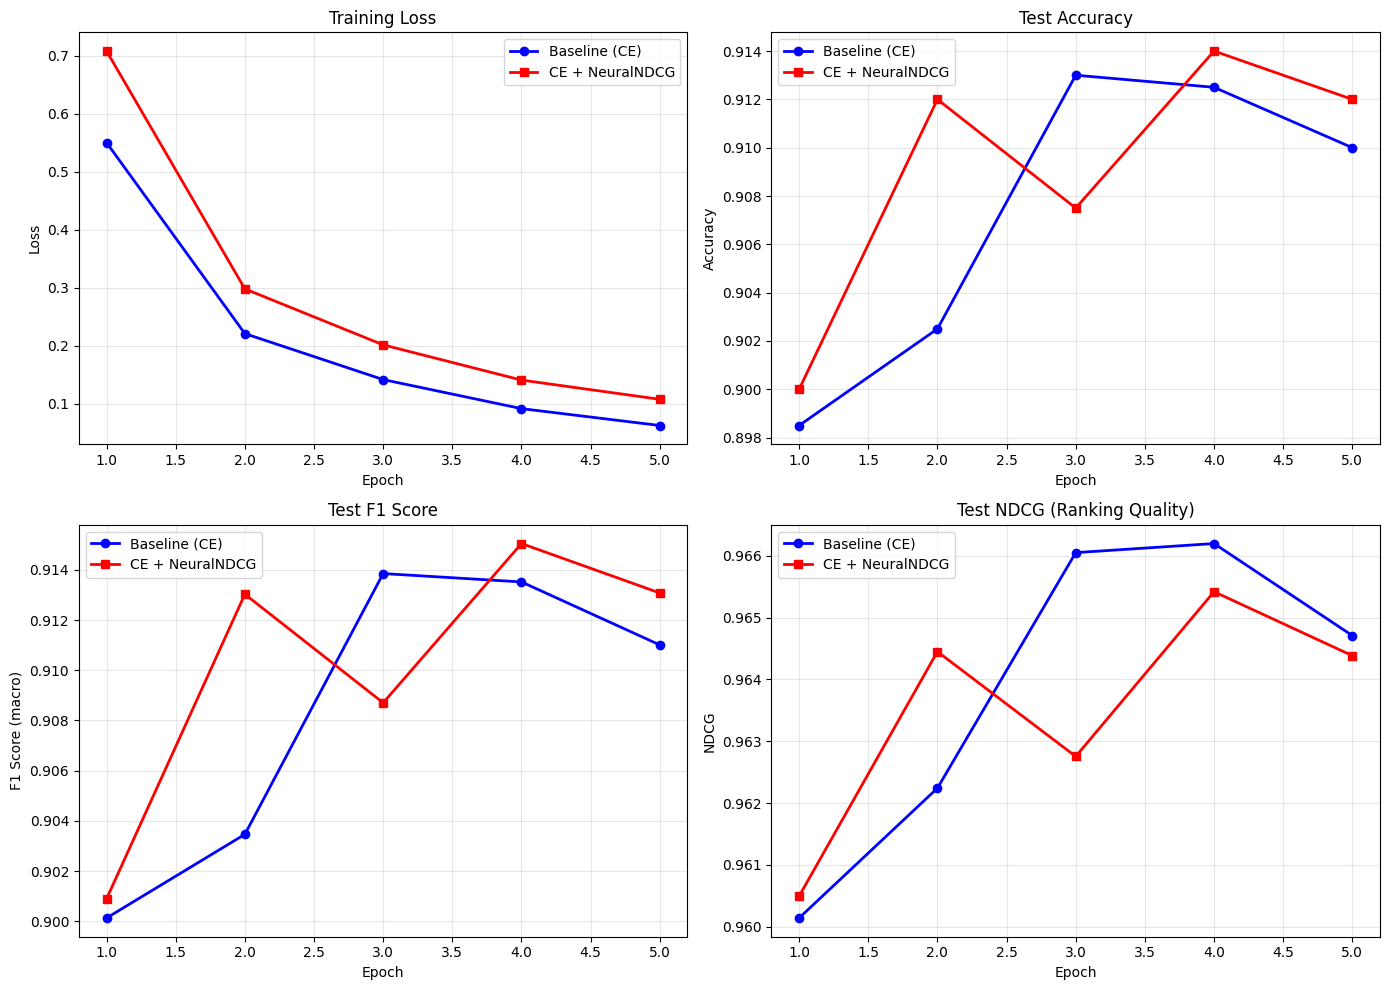

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs = range(1, NUM_EPOCHS + 1)

ax = axes[0, 0]
ax.plot(epochs, history_baseline['train_loss'], 'b-o', label='Baseline (CE)', linewidth=2)
ax.plot(epochs, history_ndcg['train_loss'], 'r-s', label='CE + NeuralNDCG', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('Training Loss')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(epochs, history_baseline['test_accuracy'], 'b-o', label='Baseline (CE)', linewidth=2)
ax.plot(epochs, history_ndcg['test_accuracy'], 'r-s', label='CE + NeuralNDCG', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.set_title('Test Accuracy')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(epochs, history_baseline['test_f1'], 'b-o', label='Baseline (CE)', linewidth=2)
ax.plot(epochs, history_ndcg['test_f1'], 'r-s', label='CE + NeuralNDCG', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('F1 Score (macro)'); ax.set_title('Test F1 Score')
ax.legend(); ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(epochs, history_baseline['test_ndcg'], 'b-o', label='Baseline (CE)', linewidth=2)
ax.plot(epochs, history_ndcg['test_ndcg'], 'r-s', label='CE + NeuralNDCG', linewidth=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('NDCG'); ax.set_title('Test NDCG (Ranking Quality)')
ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Результаты:
 - Модель с NeuralNDCG лучше по метрикам классификации, но почему-то хуже на NDCG
 - Лосс с NeuralNDCG больше, чем без него, но падает с такой же скоростью
    - Что в целом логично, тк по сути реализация с NNDCG это просто добавка к лоссу
Небольшой комментарий:
 - На train выборке в 8000 сэмплов и 4 эпохи преймущество было более выражено, причем на всех метриках
 - Поэтому скорее всего есть доля шума в метриках, но тенденция по улучшению тем не менее видна